In [97]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap



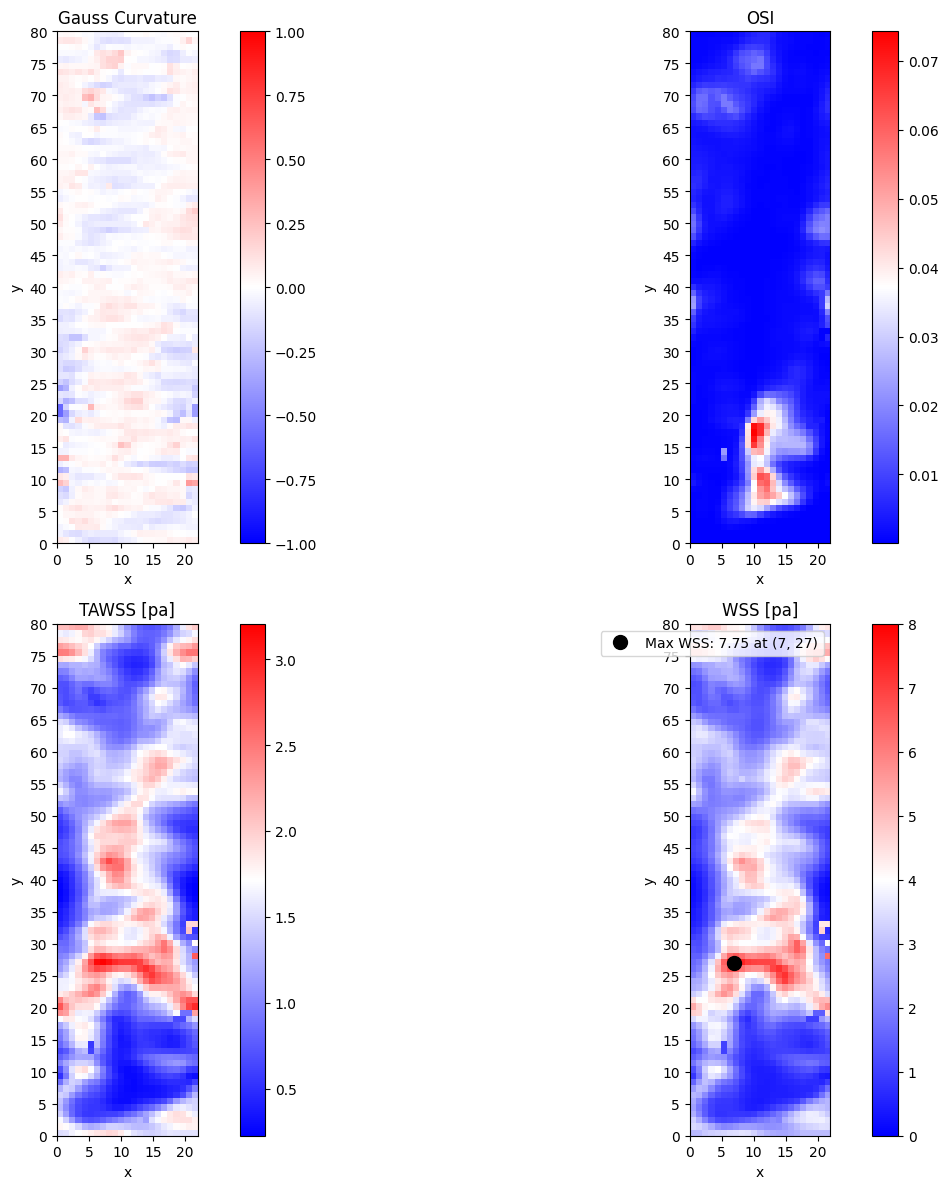

Max WSS value: 7.74759
Max WSS coordinates: (7, 27)


In [98]:
# Load the CSV file for analysis
file_path = 'CB_kabayaki.csv'  # 请替换为你文件的实际路径
df = pd.read_csv(file_path)

# Set parameters for visualization
a = 20  # Start range for y-axis
b = 100  # End range for y-axis
c = 14  # The x-value to move to x=0
d = 1  # The threshold for Gauss Curvature
e = 8  # The threshold for WSS

# Filter y values in the range of a and b
df_filtered = df[(df['y'] >= a) & (df['y'] <= b)].copy()

# Adjust y values so that 'a' becomes 0
df_filtered['y'] = df_filtered['y'] - a

# Process the mapping: move x from c to max(x) to the left (to x = 0) and append x from 0 to c-1 to the right
df_c_to_max = df_filtered[df_filtered['x'] >= c].copy()  # Data from x = c to max(x)
df_c_to_max['x'] = df_c_to_max['x'] - c  # Move these x values to 0

df_0_to_c = df_filtered[df_filtered['x'] < c].copy()  # Data from x = 0 to x = c-1
df_0_to_c['x'] = df_0_to_c['x'] + (df['x'].max() - c + 1)  # Shift these x values to the right

# Merge the data back together
df_mapped = pd.concat([df_c_to_max, df_0_to_c])

# Handle duplicate entries by averaging the values for duplicate x-y pairs
df_mapped = df_mapped.groupby(['y', 'x'], as_index=False).mean()

# Pivot the dataframe to create 2D arrays for each parameter
gauss_curvature_grid = df_mapped.pivot(index='y', columns='x', values='Gauss_Curvature').values
osi_grid = df_mapped.pivot(index='y', columns='x', values='OSI').values
tawss_grid = df_mapped.pivot(index='y', columns='x', values='TAWSS [pa]').values
wss_grid = df_mapped.pivot(index='y', columns='x', values='WSS [pa]').values

# Create a custom colormap: white at 0, blue for lower values, red for higher values
colors = ['blue', 'white', 'red']
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', colors, N=256)

# Find the position of the maximum WSS value and its coordinates based on the new y-axis
wss_max_index = np.unravel_index(np.argmax(wss_grid, axis=None), wss_grid.shape)
max_wss_value = wss_grid[wss_max_index]
max_wss_coordinates = (wss_max_index[1], wss_max_index[0])  # No need to adjust y since a is already set to 0

# Create a list of titles and grids for plotting
titles = ['Gauss Curvature', 'OSI', 'TAWSS [pa]', 'WSS [pa]']
grids = [gauss_curvature_grid, osi_grid, tawss_grid, wss_grid]

# Plot each parameter as a separate subplot in a 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

for ax, title, grid in zip(axes.ravel(), titles, grids):
    if title == 'Gauss Curvature':
        # Set vmin and vmax for Gauss Curvature to limit the range to -d to d
        c = ax.imshow(grid, origin='lower', aspect='equal', cmap=custom_cmap, vmin=-d, vmax=d, extent=(0, len(grid[0]) - 1, 0, b-a))
    elif title == 'WSS [pa]':
        # No range limit for WSS
        c = ax.imshow(grid, origin='lower', aspect='equal', cmap=custom_cmap, vmin=0, vmax=e, extent=(0, len(grid[0]) - 1, 0, b-a))
        # Highlight the max WSS position
        ax.plot(wss_max_index[1], wss_max_index[0], 'ko', markersize=10, label=f'Max WSS: {max_wss_value:.2f} at {max_wss_coordinates}')
        ax.legend()
    else:
        # Plot other parameters without limiting the range
        c = ax.imshow(grid, origin='lower', aspect='equal', cmap=custom_cmap, extent=(0, len(grid[0]) - 1, 0, b-a))
    
    ax.set_title(title)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    
    # Set axis ticks at intervals of 5
    ax.set_xticks(np.arange(0, len(grid[0]), 5))
    ax.set_yticks(np.arange(0, b-a+1, 5))
    
    fig.colorbar(c, ax=ax)

plt.tight_layout()
plt.show()

# Output max WSS value and coordinates
print(f"Max WSS value: {max_wss_value}")
print(f"Max WSS coordinates: {max_wss_coordinates}")


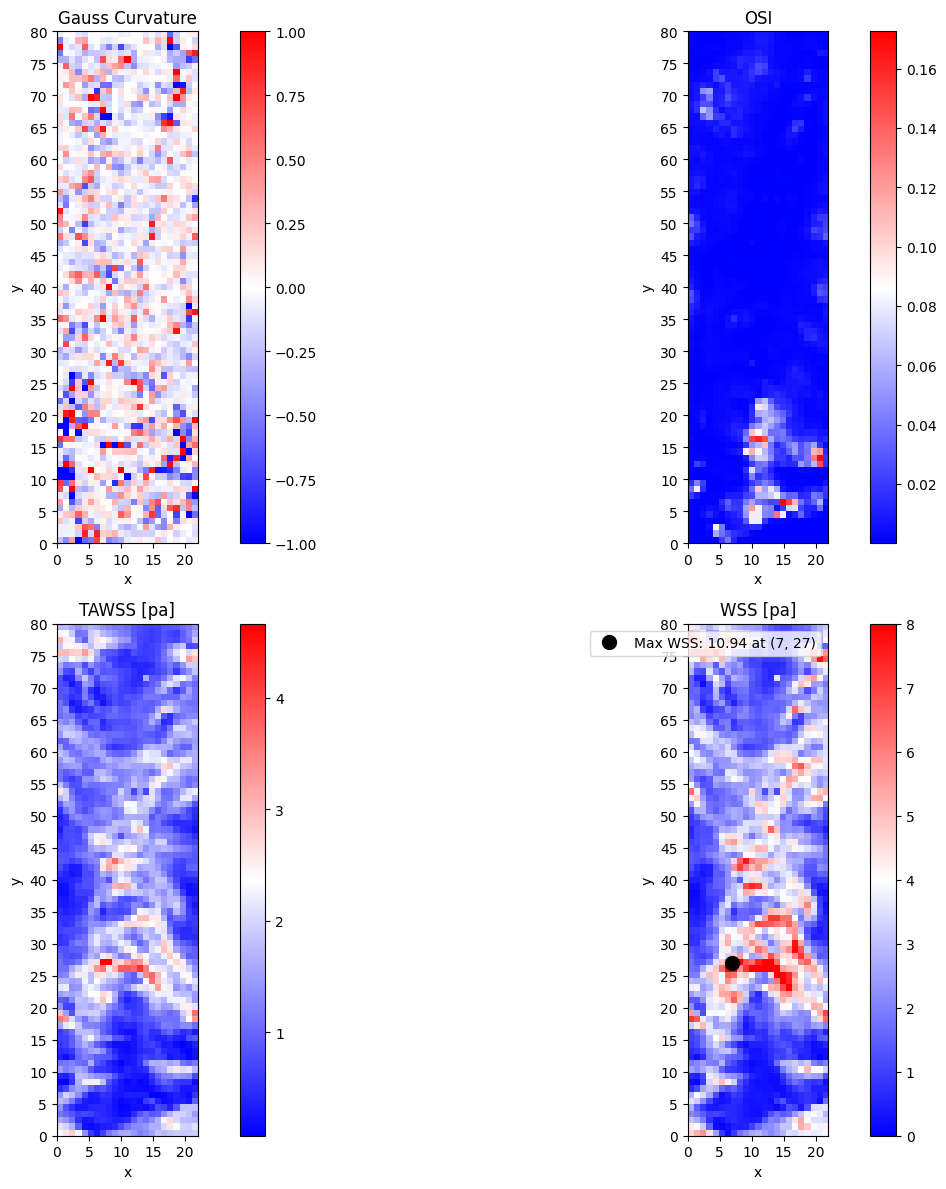

Max WSS value: 10.9438
Max WSS coordinates: (7, 27)


In [94]:
# Load the CSV file for analysis
file_path = 'TB_kabayaki.csv'  # 请替换为你文件的实际路径
df = pd.read_csv(file_path)

# Set parameters for visualization
a = 26  # Start range for y-axis
b = 106  # End range for y-axis
c = 13  # The x-value to move to x=0
d = 1  # The threshold for Gauss Curvature

# Filter y values in the range of a and b
df_filtered = df[(df['y'] >= a) & (df['y'] <= b)].copy()

# Adjust y values so that 'a' becomes 0
df_filtered['y'] = df_filtered['y'] - a

# Process the mapping: move x from c to max(x) to the left (to x = 0) and append x from 0 to c-1 to the right
df_c_to_max = df_filtered[df_filtered['x'] >= c].copy()  # Data from x = c to max(x)
df_c_to_max['x'] = df_c_to_max['x'] - c  # Move these x values to 0

df_0_to_c = df_filtered[df_filtered['x'] < c].copy()  # Data from x = 0 to x = c-1
df_0_to_c['x'] = df_0_to_c['x'] + (df['x'].max() - c + 1)  # Shift these x values to the right

# Merge the data back together
df_mapped = pd.concat([df_c_to_max, df_0_to_c])

# Handle duplicate entries by averaging the values for duplicate x-y pairs
df_mapped = df_mapped.groupby(['y', 'x'], as_index=False).mean()

# Pivot the dataframe to create 2D arrays for each parameter
gauss_curvature_grid = df_mapped.pivot(index='y', columns='x', values='Gauss_Curvature').values
osi_grid = df_mapped.pivot(index='y', columns='x', values='OSI').values
tawss_grid = df_mapped.pivot(index='y', columns='x', values='TAWSS [pa]').values
wss_grid = df_mapped.pivot(index='y', columns='x', values='WSS [pa]').values

# Create a custom colormap: white at 0, blue for lower values, red for higher values
colors = ['blue', 'white', 'red']
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', colors, N=256)

# Find the position of the maximum WSS value and its coordinates based on the new y-axis
wss_max_index = np.unravel_index(np.argmax(wss_grid, axis=None), wss_grid.shape)
max_wss_value = wss_grid[wss_max_index]
max_wss_coordinates = (wss_max_index[1], wss_max_index[0])  # No need to adjust y since a is already set to 0

# Create a list of titles and grids for plotting
titles = ['Gauss Curvature', 'OSI', 'TAWSS [pa]', 'WSS [pa]']
grids = [gauss_curvature_grid, osi_grid, tawss_grid, wss_grid]

# Plot each parameter as a separate subplot in a 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

for ax, title, grid in zip(axes.ravel(), titles, grids):
    if title == 'Gauss Curvature':
        # Set vmin and vmax for Gauss Curvature to limit the range to -d to d
        c = ax.imshow(grid, origin='lower', aspect='equal', cmap=custom_cmap, vmin=-d, vmax=d, extent=(0, len(grid[0]) - 1, 0, b-a))
    elif title == 'WSS [pa]':
        # No range limit for WSS
        c = ax.imshow(grid, origin='lower', aspect='equal', cmap=custom_cmap, vmin=0, vmax=e, extent=(0, len(grid[0]) - 1, 0, b-a))
        # Highlight the max WSS position
        ax.plot(wss_max_index[1], wss_max_index[0], 'ko', markersize=10, label=f'Max WSS: {max_wss_value:.2f} at {max_wss_coordinates}')
        ax.legend()
    else:
        # Plot other parameters without limiting the range
        c = ax.imshow(grid, origin='lower', aspect='equal', cmap=custom_cmap, extent=(0, len(grid[0]) - 1, 0, b-a))
    
    ax.set_title(title)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    
    # Set axis ticks at intervals of 5
    ax.set_xticks(np.arange(0, len(grid[0]), 5))
    ax.set_yticks(np.arange(0, b-a+1, 5))
    
    fig.colorbar(c, ax=ax)

plt.tight_layout()
plt.show()

# Output max WSS value and coordinates
print(f"Max WSS value: {max_wss_value}")
print(f"Max WSS coordinates: {max_wss_coordinates}")


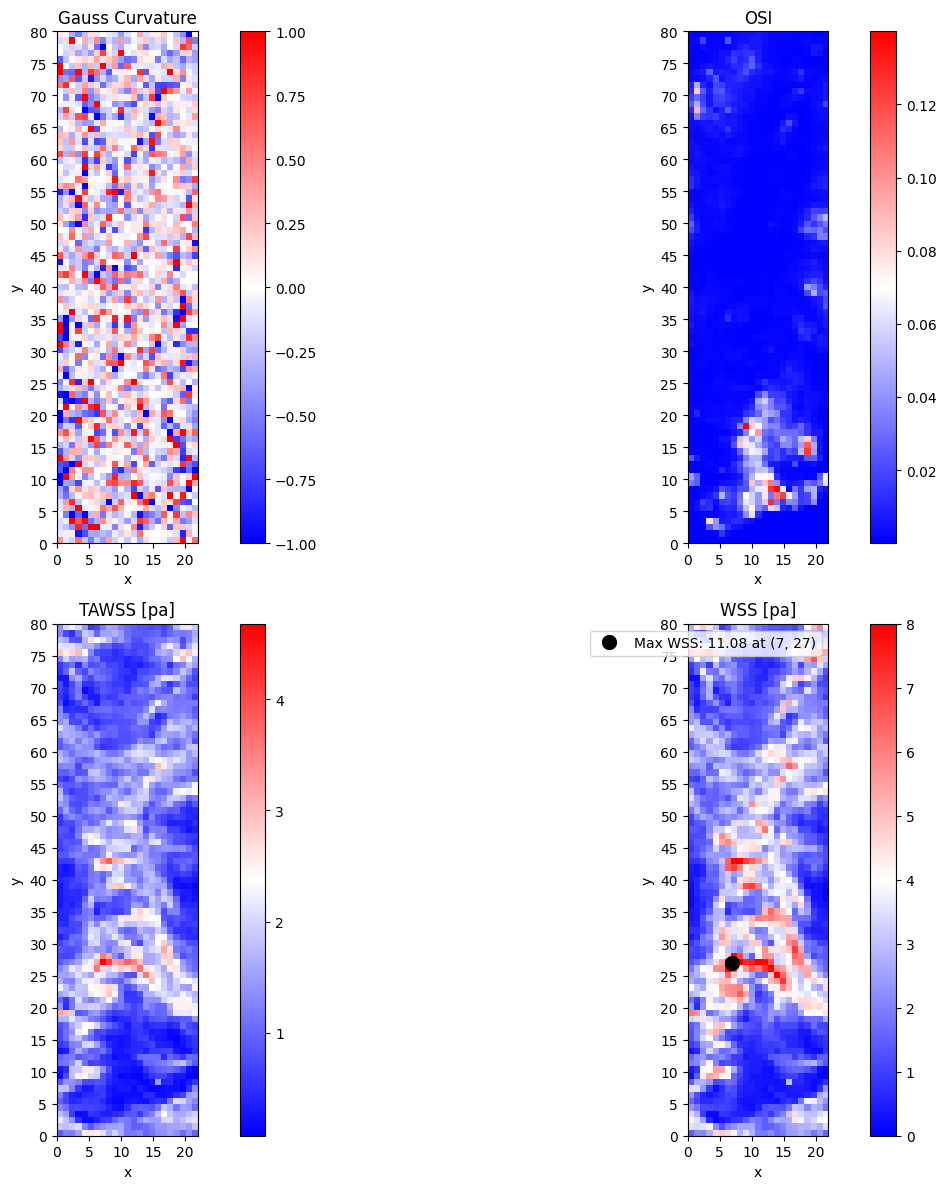

Max WSS value: 11.0777
Max WSS coordinates: (7, 27)


In [95]:
# Load the CSV file for analysis
file_path = 'LP_kabayaki.csv'  # 请替换为你文件的实际路径
df = pd.read_csv(file_path)

# Set parameters for visualization
a = 19  # Start range for y-axis
b = 99  # End range for y-axis
c = 14  # The x-value to move to x=0
d = 1  # The threshold for Gauss Curvature

# Filter y values in the range of a and b
df_filtered = df[(df['y'] >= a) & (df['y'] <= b)].copy()

# Adjust y values so that 'a' becomes 0
df_filtered['y'] = df_filtered['y'] - a

# Process the mapping: move x from c to max(x) to the left (to x = 0) and append x from 0 to c-1 to the right
df_c_to_max = df_filtered[df_filtered['x'] >= c].copy()  # Data from x = c to max(x)
df_c_to_max['x'] = df_c_to_max['x'] - c  # Move these x values to 0

df_0_to_c = df_filtered[df_filtered['x'] < c].copy()  # Data from x = 0 to x = c-1
df_0_to_c['x'] = df_0_to_c['x'] + (df['x'].max() - c + 1)  # Shift these x values to the right

# Merge the data back together
df_mapped = pd.concat([df_c_to_max, df_0_to_c])

# Handle duplicate entries by averaging the values for duplicate x-y pairs
df_mapped = df_mapped.groupby(['y', 'x'], as_index=False).mean()

# Pivot the dataframe to create 2D arrays for each parameter
gauss_curvature_grid = df_mapped.pivot(index='y', columns='x', values='Gauss_Curvature').values
osi_grid = df_mapped.pivot(index='y', columns='x', values='OSI').values
tawss_grid = df_mapped.pivot(index='y', columns='x', values='TAWSS [pa]').values
wss_grid = df_mapped.pivot(index='y', columns='x', values='WSS [pa]').values

# Create a custom colormap: white at 0, blue for lower values, red for higher values
colors = ['blue', 'white', 'red']
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', colors, N=256)

# Find the position of the maximum WSS value and its coordinates based on the new y-axis
wss_max_index = np.unravel_index(np.argmax(wss_grid, axis=None), wss_grid.shape)
max_wss_value = wss_grid[wss_max_index]
max_wss_coordinates = (wss_max_index[1], wss_max_index[0])  # No need to adjust y since a is already set to 0

# Create a list of titles and grids for plotting
titles = ['Gauss Curvature', 'OSI', 'TAWSS [pa]', 'WSS [pa]']
grids = [gauss_curvature_grid, osi_grid, tawss_grid, wss_grid]

# Plot each parameter as a separate subplot in a 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

for ax, title, grid in zip(axes.ravel(), titles, grids):
    if title == 'Gauss Curvature':
        # Set vmin and vmax for Gauss Curvature to limit the range to -d to d
        c = ax.imshow(grid, origin='lower', aspect='equal', cmap=custom_cmap, vmin=-d, vmax=d, extent=(0, len(grid[0]) - 1, 0, b-a))
    elif title == 'WSS [pa]':
        # No range limit for WSS
        c = ax.imshow(grid, origin='lower', aspect='equal', cmap=custom_cmap, vmin=0, vmax=e, extent=(0, len(grid[0]) - 1, 0, b-a))
        # Highlight the max WSS position
        ax.plot(wss_max_index[1], wss_max_index[0], 'ko', markersize=10, label=f'Max WSS: {max_wss_value:.2f} at {max_wss_coordinates}')
        ax.legend()
    else:
        # Plot other parameters without limiting the range
        c = ax.imshow(grid, origin='lower', aspect='equal', cmap=custom_cmap, extent=(0, len(grid[0]) - 1, 0, b-a))
    
    ax.set_title(title)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    
    # Set axis ticks at intervals of 5
    ax.set_xticks(np.arange(0, len(grid[0]), 5))
    ax.set_yticks(np.arange(0, b-a+1, 5))
    
    fig.colorbar(c, ax=ax)

plt.tight_layout()
plt.show()

# Output max WSS value and coordinates
print(f"Max WSS value: {max_wss_value}")
print(f"Max WSS coordinates: {max_wss_coordinates}")


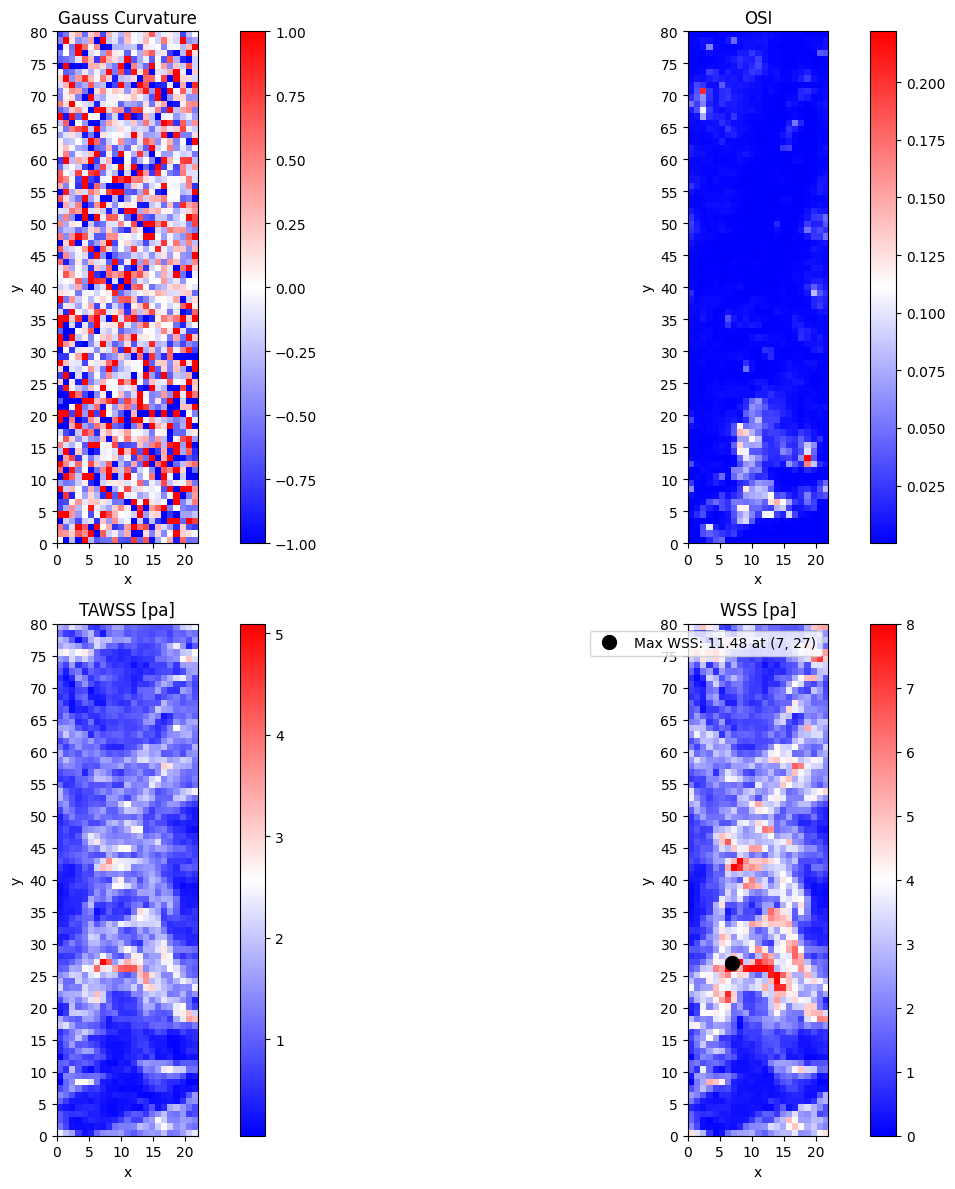

Max WSS value: 11.4839
Max WSS coordinates: (7, 27)


In [96]:
# Load the CSV file for analysis
file_path = 'OR_kabayaki.csv'  # 请替换为你文件的实际路径
df = pd.read_csv(file_path)

# Set parameters for visualization
a = 21  # Start range for y-axis
b = 101  # End range for y-axis
c = 15  # The x-value to move to x=0
d = 1  # The threshold for Gauss Curvature

# Filter y values in the range of a and b
df_filtered = df[(df['y'] >= a) & (df['y'] <= b)].copy()

# Adjust y values so that 'a' becomes 0
df_filtered['y'] = df_filtered['y'] - a

# Process the mapping: move x from c to max(x) to the left (to x = 0) and append x from 0 to c-1 to the right
df_c_to_max = df_filtered[df_filtered['x'] >= c].copy()  # Data from x = c to max(x)
df_c_to_max['x'] = df_c_to_max['x'] - c  # Move these x values to 0

df_0_to_c = df_filtered[df_filtered['x'] < c].copy()  # Data from x = 0 to x = c-1
df_0_to_c['x'] = df_0_to_c['x'] + (df['x'].max() - c + 1)  # Shift these x values to the right

# Merge the data back together
df_mapped = pd.concat([df_c_to_max, df_0_to_c])

# Handle duplicate entries by averaging the values for duplicate x-y pairs
df_mapped = df_mapped.groupby(['y', 'x'], as_index=False).mean()

# Pivot the dataframe to create 2D arrays for each parameter
gauss_curvature_grid = df_mapped.pivot(index='y', columns='x', values='Gauss_Curvature').values
osi_grid = df_mapped.pivot(index='y', columns='x', values='OSI').values
tawss_grid = df_mapped.pivot(index='y', columns='x', values='TAWSS [pa]').values
wss_grid = df_mapped.pivot(index='y', columns='x', values='WSS [pa]').values

# Create a custom colormap: white at 0, blue for lower values, red for higher values
colors = ['blue', 'white', 'red']
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', colors, N=256)

# Find the position of the maximum WSS value and its coordinates based on the new y-axis
wss_max_index = np.unravel_index(np.argmax(wss_grid, axis=None), wss_grid.shape)
max_wss_value = wss_grid[wss_max_index]
max_wss_coordinates = (wss_max_index[1], wss_max_index[0])  # No need to adjust y since a is already set to 0

# Create a list of titles and grids for plotting
titles = ['Gauss Curvature', 'OSI', 'TAWSS [pa]', 'WSS [pa]']
grids = [gauss_curvature_grid, osi_grid, tawss_grid, wss_grid]

# Plot each parameter as a separate subplot in a 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

for ax, title, grid in zip(axes.ravel(), titles, grids):
    if title == 'Gauss Curvature':
        # Set vmin and vmax for Gauss Curvature to limit the range to -d to d
        c = ax.imshow(grid, origin='lower', aspect='equal', cmap=custom_cmap, vmin=-d, vmax=d, extent=(0, len(grid[0]) - 1, 0, b-a))
    elif title == 'WSS [pa]':
        # No range limit for WSS
        c = ax.imshow(grid, origin='lower', aspect='equal', cmap=custom_cmap, vmin=0, vmax=e, extent=(0, len(grid[0]) - 1, 0, b-a))
        # Highlight the max WSS position
        ax.plot(wss_max_index[1], wss_max_index[0], 'ko', markersize=10, label=f'Max WSS: {max_wss_value:.2f} at {max_wss_coordinates}')
        ax.legend()
    else:
        # Plot other parameters without limiting the range
        c = ax.imshow(grid, origin='lower', aspect='equal', cmap=custom_cmap, extent=(0, len(grid[0]) - 1, 0, b-a))
    
    ax.set_title(title)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    
    # Set axis ticks at intervals of 5
    ax.set_xticks(np.arange(0, len(grid[0]), 5))
    ax.set_yticks(np.arange(0, b-a+1, 5))
    
    fig.colorbar(c, ax=ax)

plt.tight_layout()
plt.show()

# Output max WSS value and coordinates
print(f"Max WSS value: {max_wss_value}")
print(f"Max WSS coordinates: {max_wss_coordinates}")
